# Домашнее задание 1. Сравнение методов коллаборативной фильтрации по сходству пользователей и по сходству объектов


Полезная ссылка на довольно подробный обзор по теме: http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf


1. Загрузите данные [Movie Lens](http://grouplens.org/datasets/movielens/), датасет на 1М рейтингов. Дополнительный бонус, если ваш код сможет обработать датасет на 10М. Я рекомендую сначала пробовать ваши методы на датасете из 100к рейтингов.  

2. Разбейте датасет на обучающую и тестовую выборку. 

Вариант 1: Тестовые пользователи -- это те, у кого ID делется на 5 без остатка.
Для каждого тестового пользователя скройте каждый десятый фильм по возрастанию ID.

Вариант 2: Тестовые пользователи -- это случайно выбранные 20% сохраните их список для воспроизводимости.
Для каждого тестового пользователя скройте каждый фильм с вероятностью 1/10, сохраните список скрытых фильмов.

Все пользователи и не скрытые фильмы это данные, на которых вы будете оценивать похожесть.

3. Выберите любые две меры похожести и реализуйте на их основе две модели рекомендаций на основе пользователей.
Для этих моделей посчитайте MAE и RMSE на всех скрытых оценках варианта 1. Какая модель оказалась лучше?

4. Повторите пункт 3 для варианта 2. Изменилось ли что-нибудь?

5. Для каждого тестового пользователя сгенерируйте рекомендации топ 10, 15, 20, 50, 100 фильмов у которых нет оценок. Посчитайте NDCG считая хорошими фильмы с оценкой 4 и выше.

6. Реализуте модель основанную на похожести предметов.

7. Повторите пункты 3-5 для этой модели. 

8. Насколько различны списки из top-n рекомендаций. Попробуйте улучшить результаты подбором $\beta$ для минимизации MAE (RMSE) в гибридных рекомендациях:
$$\beta\cdot r^{user-based}_{ui} + (1-\beta)\cdot r^{item-based}_{ui}, \mbox{ где } 0 \leq \beta \leq 1.$$ 

deadline 24.10.2021 23:59

я сделал пункты 1-7, реализовал индивидуальное взвешивание для пользователей, что-то типа Z-score
запустил скрипт для 10М, и он вроде даже работает
пункт 8 тоже сделал

In [1]:
from math import sqrt
from math import log2
from math import isnan

from random import random, seed
from collections import defaultdict
from itertools import islice

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ndcg_score
from sklearn.neighbors import NearestNeighbors

# Load date

In [2]:
#Чтение данных
def loadMovieLens1M(path='./ml-1m'):
    # Получить названия фильмов
    movies={}
    for line in open(path+'/movies.dat'):
        (id,title)=line.split('::')[0:2] #при желании тут можно добавить чтение жанров.
        movies[id]=title
    # Загрузить данные
    prefs={}
    for line in open(path+'/ratings.dat'):
        (user,movieid,rating,ts)=line.split('::')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
    return prefs

In [3]:
critics = loadMovieLens1M()
pd.DataFrame.from_dict(critics).head()

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
One Flew Over the Cuckoo's Nest (1975),5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,5.0,NaN,5.0,5.0,4.0,NaN,NaN,4.0
James and the Giant Peach (1996),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
My Fair Lady (1964),3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,4.0,NaN
Erin Brockovich (2000),4.0,NaN,NaN,NaN,3.0,5.0,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
"Bug's Life, A (1998)",5.0,NaN,5.0,NaN,5.0,NaN,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN


## test train split

### Вариант 1:
Тестовые пользователи – это те, у кого ID делется на 5 без остатка. Для каждого тестового пользователя скройте каждый десятый фильм по возрастанию ID

In [4]:
all_users = [u for u in critics]
len(all_users)

6040

In [5]:
users_test_list = [u for u in critics if int(u) % 5 == 0]
len(users_test_list)

1208

In [6]:
critics_test = {}
# critics_train = {}
for u in users_test_list:
    critics_test[u] = {}
    # critics_train[u] = {}
    m_id = 0
    for m in critics[u]:
        m_id += 1
        if m_id % 10 == 0:
            critics_test[u][m] = critics[u][m]
        # else:
        #     critics_train[u][m] = critics[u][m]
pd.DataFrame.from_dict(critics_test).head()

,5,10,15,20,25,30,35,40,45,50,...,5995,6000,6005,6010,6015,6020,6025,6030,6035,6040
Donnie Brasco (1997),3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gladiator (2000),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seven (Se7en) (1995),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Apollo 13 (1995),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Usual Suspects, The (1995)",5.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
critics_train = {}
for u in all_users:
    if u not in users_test_list:
        critics_train[u] = {}
        for m in critics[u]:
            critics_train[u][m] = critics[u][m]
    else:
        critics_train[u] = {}
        m_id = 0
        for m in critics[u]:
            m_id += 1
            if m_id % 10 == 0:
                critics_train[u][m] = critics[u][m]

pd.DataFrame.from_dict(critics_train).head()

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
One Flew Over the Cuckoo's Nest (1975),5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,5.0,NaN,NaN,5.0,4.0,NaN,NaN,NaN
James and the Giant Peach (1996),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
My Fair Lady (1964),3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,4.0,NaN
Erin Brockovich (2000),4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
"Bug's Life, A (1998)",5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


### Вариант 2:
Тестовые пользователи – это случайно выбранные 20% сохраните их список для воспроизводимости. Для каждого тестового пользователя скройте каждый фильм с вероятностью 1/10, сохраните список скрытых фильмов.

In [8]:
seed(2)
users_test_list_2 = [u for u in critics if random()<=0.2]
len(users_test_list_2)

1175

In [9]:
seed(2)
critics_test_2 = {}
critics_train_2_ = {}
for u in users_test_list_2:
    critics_test_2[u] = {}
    critics_train_2_[u] = {}
    for m in critics[u]:
        if random()<=0.2:
            critics_test_2[u][m] = critics[u][m]
        else:
            critics_train_2_[u][m] = critics[u][m]
pd.DataFrame.from_dict(critics_test_2).head()

,3,4,12,21,22,30,32,36,46,66,...,6000,6006,6008,6018,6021,6025,6028,6031,6032,6037
Mission: Impossible (1996),3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Raising Arizona (1987),4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
Being John Malkovich (1999),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.0
American Beauty (1999),4.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Toy Story 2 (1999),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
pd.DataFrame.from_dict(critics_train_2_).head()

,3,4,12,21,22,30,32,36,46,66,...,6000,6006,6008,6018,6021,6025,6028,6031,6032,6037
Animal House (1978),4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
"Full Monty, The (1997)",2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28 Days (2000),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Happy Gilmore (1996),4.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
"Golden Child, The (1986)",4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
critics_train_2 = {}
for u in all_users:
    if u not in users_test_list_2:
        critics_train_2[u] = {}
        for m in critics[u]:
            critics_train_2[u][m] = critics[u][m]
    else:
        critics_train_2[u] = {}
        for m in critics[u]:
            if m not in [m for m in critics_train_2_[u]]:
                critics_train_2[u][m] = critics[u][m]
pd.DataFrame.from_dict(critics_train_2).head()

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
One Flew Over the Cuckoo's Nest (1975),5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,5.0,5.0,NaN,NaN,NaN,4.0
James and the Giant Peach (1996),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
My Fair Lady (1964),3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,4.0,NaN
Erin Brockovich (2000),4.0,NaN,NaN,NaN,3.0,5.0,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
"Bug's Life, A (1998)",5.0,NaN,5.0,NaN,5.0,NaN,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN


### Выберите любые две меры похожести и реализуйте на их основе две модели рекомендаций на основе пользователей.

In [12]:
# Возвращает сходство person1 и person2 на основе расстояния
def sim_kernel(prefs,person1,person2,alpha=0.3):
    # Получить список предметов, оцененных обоими
    si={}
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item]=1
    # Если нет ни одной общей оценки, вернуть 0
    if len(si)==0: return 0
    # Сложить квадраты разностей
    sum_of_squares=sum([pow(prefs[person1][item]-prefs[person2][item],2)
                        for item in prefs[person1] if item in prefs[person2]])
    return np.exp(-alpha*sum_of_squares)


# Возвращает коэффициент корреляции Пирсона между p1 и p2
def sim_pearson(prefs,p1,p2):
    # Получить список предметов, оцененных обоими
    si={}
    for item in prefs[p1]:
        if item in prefs[p2]: si[item]=1

    # Если нет ни одной общей оценки, вернуть 0
    if len(si)==0: return 0

    # Количество соместно оцененных фильм
    n=len(si)

    # Вычислить сумму всех предпочтений
    sum1=sum([prefs[p1][it] for it in si])
    sum2=sum([prefs[p2][it] for it in si])

    # Вычислить сумму квадратов
    sum1Sq=sum([pow(prefs[p1][it],2) for it in si])
    sum2Sq=sum([pow(prefs[p2][it],2) for it in si])

    # Вычислить сумму произведений
    pSum=sum([prefs[p1][it]*prefs[p2][it] for it in si])

    # Вычислить коэффициент Пирсона
    num=pSum-(sum1*sum2/n)
    den=sqrt((sum1Sq-pow(sum1,2)/n)*(sum2Sq-pow(sum2,2)/n))
    if den==0: return 0

    r=round(num/den, 2)

    return r

In [13]:
list(islice(critics_test.items(), 1))

[('5',
  {'Donnie Brasco (1997)': 3.0,
   'Gladiator (2000)': 2.0,
   'Seven (Se7en) (1995)': 3.0,
   'Apollo 13 (1995)': 2.0,
   'Usual Suspects, The (1995)': 5.0,
   'Thin Red Line, The (1998)': 5.0,
   'Ghostbusters (1984)': 3.0,
   'Topsy-Turvy (1999)': 5.0,
   'Go (1999)': 4.0,
   'Fargo (1996)': 4.0,
   'Fast, Cheap & Out of Control (1997)': 4.0,
   'Fight Club (1999)': 4.0,
   "Jacob's Ladder (1990)": 3.0,
   'Incredibly True Adventure of Two Girls in Love, The (1995)': 3.0,
   'Waiting for Guffman (1996)': 4.0,
   'In the Company of Men (1997)': 1.0,
   'Bullets Over Broadway (1994)': 4.0,
   'Much Ado About Nothing (1993)': 3.0,
   'Rosencrantz and Guildenstern Are Dead (1990)': 3.0})]

In [14]:
def topMatches(prefs,person,n=25,similarity=sim_pearson):
    sim_list = sorted([(similarity(prefs, person, p), p) for p in prefs if p != person],
                      reverse = True)
    return sim_list[:n]

In [15]:

topMatches(critics_train, list(critics_test.keys())[0])

[(1.0, '993'),
 (1.0, '97'),
 (1.0, '964'),
 (1.0, '893'),
 (1.0, '887'),
 (1.0, '88'),
 (1.0, '838'),
 (1.0, '811'),
 (1.0, '78'),
 (1.0, '773'),
 (1.0, '764'),
 (1.0, '753'),
 (1.0, '734'),
 (1.0, '723'),
 (1.0, '717'),
 (1.0, '710'),
 (1.0, '68'),
 (1.0, '657'),
 (1.0, '628'),
 (1.0, '613'),
 (1.0, '6022'),
 (1.0, '5992'),
 (1.0, '5988'),
 (1.0, '5981'),
 (1.0, '5919')]

In [16]:
# Получить рекомендации для заданного человека, пользуясь взвешенным средним
# оценок, данных всеми остальными пользователями
def getRecommendations(prefs, test,person,similarity=sim_pearson,
                       mode = "exact"):
    top_persons = topMatches(prefs,person, 100, similarity)
    film_sum = {}
    film_multiplyer = {}
    for p in top_persons:
        if p[0] <= 0:
            break
        if mode != "exact":
            for movie in prefs[p[1]]:
                if not movie in film_sum:
                    film_sum[movie] = 0
                    film_multiplyer[movie] = 0

                film_sum[movie] += prefs[p[1]][movie]*p[0]
                film_multiplyer[movie] += p[0]
        if mode == "exact":
            test_list = test[person]
            for movie in prefs[p[1]]:
                if movie in test_list:
                    if not movie in film_sum:
                        film_sum[movie] = 0
                        film_multiplyer[movie] = 0

                    film_sum[movie] += prefs[p[1]][movie]*p[0]
                    film_multiplyer[movie] += p[0]

    if mode == "only_NA":
        recomend = sorted([(movie, film_sum[movie]/film_multiplyer[movie]) for movie in film_sum if movie not in prefs[person]], reverse = True)
    elif mode == "all":
        recomend = sorted([(movie, film_sum[movie]/film_multiplyer[movie]) for movie in film_sum], reverse = True)
    elif mode == "exact":
        recomend = sorted([(movie, film_sum[movie]/film_multiplyer[movie]) for movie in film_sum if movie in test_list], reverse = True)

    return dict(recomend)

In [17]:
# Как же я доволен собой, господь
def getRecommendations_weighted(prefs, test, person,similarity=sim_pearson,
                               mode = "exact"):
    '''
    :param prefs: train df
    :param person: test df
    :param similarity: method for user user sim
    :param test_list: list of items to predict
    :return: dict with movies and ratings
    '''
    top_persons = topMatches(prefs,person, 100, similarity)
    test_list = test[person]
    film_sum = {}
    film_multiplyer = {}
    # user 1 average
    person_mean = np.mean(list(prefs[person].values()))
    for p in top_persons:
        # user_ratings = []
        user_ratings_2 = {}
        # берём только от похожих
        if p[0] <= 0.5:
            break
        for movie in prefs[p[1]]:
            ## считаем среднюю оценку и стандартное отклонение других пользователей
            # user_ratings.append(prefs[p[1]][movie])
            user_ratings_2[movie] = prefs[p[1]][movie]
            if mode == "exact":
                if movie in test_list:
                    if not movie in film_sum:
                        film_sum[movie] = 0
                        film_multiplyer[movie] = 0

                    ### типа з скор что-ли
                    film_sum[movie] += p[0] * (prefs[p[1]][movie] - np.array(list(user_ratings_2.values())).mean()) / (np.array(list(user_ratings_2.values())).std() + 0.000000000001)
                    film_multiplyer[movie] += p[0]
            if mode == "only_NA":
                if not movie in film_sum:
                    film_sum[movie] = 0
                    film_multiplyer[movie] = 0
                    ### типа з скор что-ли
                film_sum[movie] += p[0] * (prefs[p[1]][movie] - np.array(list(user_ratings_2.values())).mean()) / (np.array(list(user_ratings_2.values())).std() + 0.000000000001)
                film_multiplyer[movie] += p[0]
    ## добавляем среднюю оценку изначального пользователя
    if mode == "exact":
        recomend = sorted([(movie, person_mean + film_sum[movie]/film_multiplyer[movie]) for movie in film_sum], reverse = True)
    if mode == "only_NA":
        recomend = sorted([(movie, person_mean + film_sum[movie]/film_multiplyer[movie]) for movie in film_sum if movie not in prefs[person]], reverse = True)

    return dict(recomend)

In [18]:
%%time
rec1 = getRecommendations(critics_train, critics_test, list(critics_test.keys())[0],
                   mode = "exact",)
rec1

Wall time: 41.7 ms


{'Waiting for Guffman (1996)': 4.666666666666667,
 'Usual Suspects, The (1995)': 4.916666666666667,
 'Topsy-Turvy (1999)': 4.5,
 'Thin Red Line, The (1998)': 4.75,
 'Seven (Se7en) (1995)': 3.0,
 'Rosencrantz and Guildenstern Are Dead (1990)': 4.0,
 'Much Ado About Nothing (1993)': 4.0,
 "Jacob's Ladder (1990)": 3.4,
 'Incredibly True Adventure of Two Girls in Love, The (1995)': 3.5,
 'In the Company of Men (1997)': 2.0,
 'Go (1999)': 4.555555555555555,
 'Gladiator (2000)': 3.515151515151515,
 'Ghostbusters (1984)': 3.5357142857142856,
 'Fight Club (1999)': 4.739130434782608,
 'Fast, Cheap & Out of Control (1997)': 4.333333333333333,
 'Fargo (1996)': 4.4324324324324325,
 'Donnie Brasco (1997)': 3.6,
 'Bullets Over Broadway (1994)': 4.428571428571429,
 'Apollo 13 (1995)': 3.5833333333333335}

In [19]:
%%time
rec2 = getRecommendations_weighted(critics_train, critics_test,
                            person=list(critics_test.keys())[1])
rec2

Wall time: 61.9 ms


{'While You Were Sleeping (1995)': 4.60855995962684,
 'Twelve Monkeys (1995)': 4.8780035984657655,
 'Teenage Mutant Ninja Turtles (1990)': 2.7131571989514667,
 'Star Trek: The Wrath of Khan (1982)': 3.030221698714085,
 'Star Trek: Generations (1994)': 4.44897403710044,
 'Soylent Green (1973)': 3.6558047010178383,
 'So I Married an Axe Murderer (1993)': 3.5399004647394356,
 'Santa Claus: The Movie (1985)': 3.610109684254234,
 'Raising Arizona (1987)': 3.577824431252283,
 'Princess Bride, The (1987)': 5.07565336610537,
 'Planet of the Apes (1968)': 3.960343690065309,
 "Mr. Holland's Opus (1995)": 4.765987153500352,
 'Message in a Bottle (1999)': 3.5120003999572837,
 'Little Mermaid, The (1989)': 4.8284206774447975,
 'Last of the Mohicans, The (1992)': 3.962614067047637,
 'Jungle Book, The (1967)': 3.2192864210647736,
 'Jerk, The (1979)': 3.5895746124277053,
 'Jack (1996)': 4.430386077045802,
 'High Fidelity (2000)': 3.4860546666174086,
 'Hamlet (1990)': 4.01273532476396,
 'Graduate, The 

### Для этих моделей посчитайте MAE и RMSE на всех скрытых оценках варианта 1. Какая модель оказалась лучше?

In [20]:
def my_score(real, predicted, score = "MAE"):
    results = {}
    if score == "MAE":
        for movie in predicted:
            results[movie] = abs(real[movie] - predicted[movie])
        result_score = np.average(list(results.values()))
    elif score == "RMSE":
        for movie in predicted:
            results[movie] = (real[movie] - predicted[movie])**2
        result_score = sqrt(np.average(list(results.values())))

    return result_score

In [21]:
my_score(critics_test[list(critics_test.keys())[0]],
         getRecommendations_weighted(critics_train,critics_test,
                                     person=list(critics_test.keys())[0],
                                        mode = "exact")
         )

0.43979492323589414

In [22]:
my_score(critics_test[list(critics_test.keys())[0]],
         getRecommendations_weighted(critics_train,critics_test,
                                     person = list(critics_test.keys())[0],
                                     mode = "exact"),
         score = "RMSE")

0.5801772699752756

## MAE

In [24]:
def evaluate_model(train, test,
                   rec_func = getRecommendations_weighted,
                   score_func = my_score):

    errors_mae = {}
    errors_rmse = {}
    for u in test:
        user_predicted = rec_func(prefs=train, test=test,
                                            person = u,
                                            mode = "exact")
        errors_mae[u] = score_func(test[u], user_predicted, score="MAE")
        errors_rmse[u] = score_func(test[u], user_predicted, score="RMSE")
    return errors_mae, errors_rmse

In [25]:
%%time
errors_base_MAE,errors_base_RMSE =  evaluate_model(critics_train, critics_test,
                                                   rec_func = getRecommendations)

errors_clear_MAE = {k: errors_base_MAE[k] for k in errors_base_MAE if not isnan(errors_base_MAE[k])}
errors_clear_RMSE = {k: errors_base_RMSE[k] for k in errors_base_RMSE if not isnan(errors_base_RMSE[k])}

print("mean error for base-level model:")
print(np.mean(list(errors_clear_MAE.values())))
print("mean error for base-level model:")
print(np.mean(list(errors_clear_RMSE.values())))

C:\Users\wirze\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\wirze\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean error for base-level model:
0.5870481473043274
mean error for base-level model:
0.7098542979801116
Wall time: 39.8 s


In [26]:
%%time
errors_weighted_MAE,errors_weighted_RMSE = evaluate_model(critics_train, critics_test,
                                                   rec_func = getRecommendations_weighted)

errors_clear_MAE = {k: errors_weighted_MAE[k] for k in errors_weighted_MAE \
                    if not isnan(errors_weighted_MAE[k])}
errors_clear_RMSE = {k: errors_weighted_RMSE[k] for k in errors_weighted_RMSE \
                     if not isnan(errors_weighted_RMSE[k])}

print("mean error for z-score model:")
print(np.mean(list(errors_clear_MAE.values())))
print("RMSE for z-score model:")
print(np.mean(list(errors_clear_RMSE.values())))

mean error for z-score model:
0.5056662452818075
RMSE for z-score model:
0.6170639663852051
Wall time: 50.7 s


In [27]:
df_errors_1 = pd.DataFrame(
    {'value': [*list(errors_base_MAE.values()),
                *list(errors_base_RMSE.values()),
                *list(errors_weighted_MAE.values()),
                *list(errors_weighted_RMSE.values())],
     'metric': [*np.repeat("MAE", len(errors_base_MAE.values()), axis=0),
               *np.repeat("RMSE", len(errors_base_RMSE.values()), axis=0),
               *np.repeat("MAE", len(errors_weighted_MAE.values()), axis=0),
               *np.repeat("RMSE", len(errors_weighted_RMSE.values()), axis=0)],
     'Model': [*np.repeat("base", len(errors_base_MAE.values()), axis=0),
               *np.repeat("base", len(errors_base_RMSE.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_MAE.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_RMSE.values()), axis=0)]}
)
df_errors_1.tail()

,value,metric,Model
4827,0.528545,RMSE,weighted
4828,0.983850,RMSE,weighted
4829,0.752316,RMSE,weighted
4830,1.270042,RMSE,weighted
4831,1.002084,RMSE,weighted


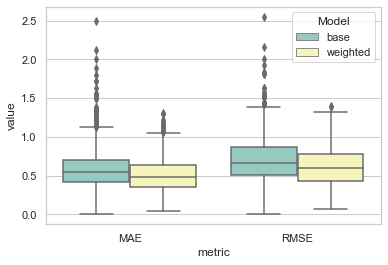

In [28]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="metric", y="value", hue="Model",
                 data=df_errors_1, palette="Set3")

If we are comparing two recommendation models by mean MAE and RMSE on all test users, it will be clear that weighted models is way better
## sampling 2

In [32]:
%%time
errors_base_MAE,errors_base_RMSE =  evaluate_model(critics_train_2, critics_test_2,
                                                   rec_func = getRecommendations)

errors_clear_MAE = {k: errors_base_MAE[k] for k in errors_base_MAE if not isnan(errors_base_MAE[k])}
errors_clear_RMSE = {k: errors_base_RMSE[k] for k in errors_base_RMSE if not isnan(errors_base_RMSE[k])}

print("mean error for base-level model:")
print(np.mean(list(errors_clear_MAE.values())))
print("mean error for base-level model:")
print(np.mean(list(errors_clear_RMSE.values())))

C:\Users\wirze\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\wirze\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean error for base-level model:
0.5816095572395393
mean error for base-level model:
0.7374463697701257
Wall time: 57.9 s


In [33]:
%%time
errors_weighted_MAE,errors_weighted_RMSE = evaluate_model(critics_train_2, critics_test_2,
                                                          rec_func = getRecommendations_weighted)

errors_clear_MAE = {k: errors_weighted_MAE[k] for k in errors_weighted_MAE
                    if not isnan(errors_weighted_MAE[k])}
errors_clear_RMSE = {k: errors_weighted_RMSE[k] for k in errors_weighted_RMSE
                     if not isnan(errors_weighted_RMSE[k])}

print("mean error for z-score model:")
print(np.mean(list(errors_clear_MAE.values())))
print("RMSE for z-score model:")
print(np.mean(list(errors_clear_RMSE.values())))

mean error for z-score model:
0.5461450529008043
RMSE for z-score model:
0.6864125569261842
Wall time: 1min 8s


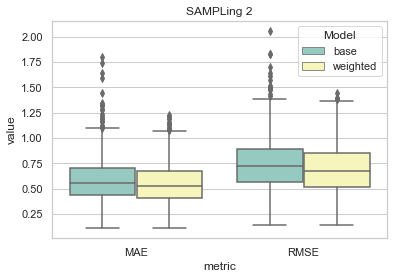

In [34]:
df_errors = pd.DataFrame(
    {'value': [*list(errors_base_MAE.values()),
                *list(errors_base_RMSE.values()),
                *list(errors_weighted_MAE.values()),
                *list(errors_weighted_RMSE.values())],
     'metric': [*np.repeat("MAE", len(errors_base_MAE.values()), axis=0),
               *np.repeat("RMSE", len(errors_base_RMSE.values()), axis=0),
               *np.repeat("MAE", len(errors_weighted_MAE.values()), axis=0),
               *np.repeat("RMSE", len(errors_weighted_RMSE.values()), axis=0)],
     'Model': [*np.repeat("base", len(errors_base_MAE.values()), axis=0),
               *np.repeat("base", len(errors_base_RMSE.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_MAE.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_RMSE.values()), axis=0)]}
)
ax = sns.boxplot(x="metric", y="value", hue="Model",
                 data=df_errors, palette="Set3")
ax.set_title('SAMPLing 2')
plt.show()

ok it looks like that error for sample 2 is larger, but lets compare it

In [35]:
df_errors_1['sample'] = 1
df_errors['sample'] = 2

In [36]:
df_errors_all = pd.concat([df_errors_1, df_errors])
df_errors_all

,value,metric,Model,sample
0,0.638064,MAE,base,1
1,0.710178,MAE,base,1
2,0.447585,MAE,base,1
3,NaN,MAE,base,1
4,0.408339,MAE,base,1
...,...,...,...,...
4695,0.970670,RMSE,weighted,2
4696,0.715895,RMSE,weighted,2
4697,0.677735,RMSE,weighted,2
4698,0.533087,RMSE,weighted,2


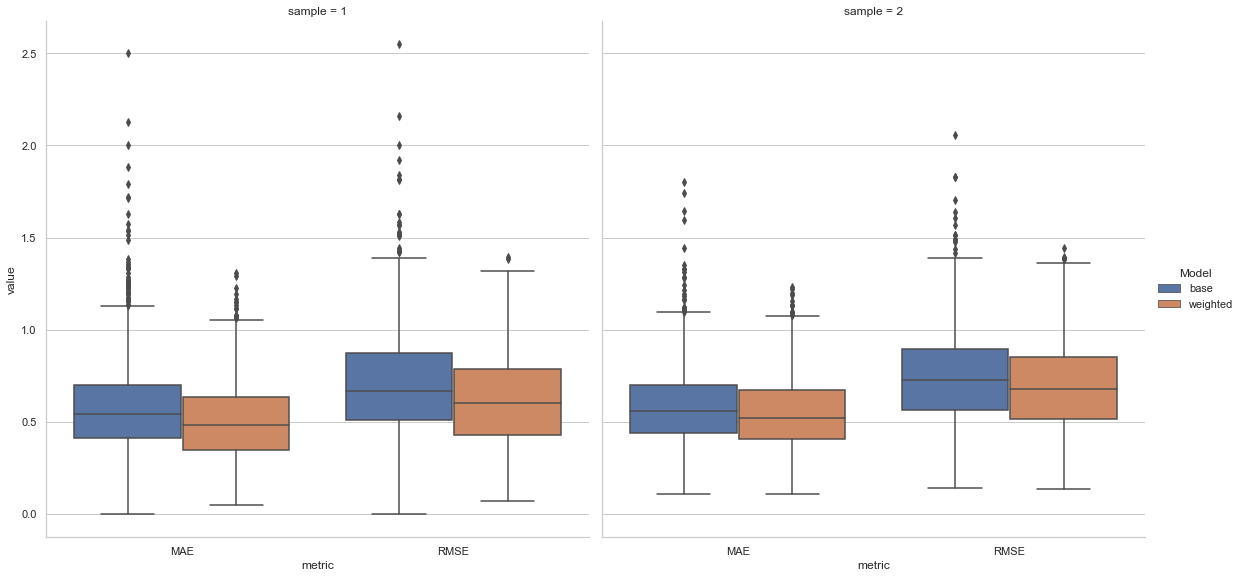

In [37]:
g = sns.catplot(x="metric", y="value", hue="Model",
                col="sample",
                data=df_errors_all, kind="box",
                height=8, aspect=1)

to be honest I have no idea why does pseudo random sampling shows better results, but anyway I will claim it to be withing margin of error, and not some kind of systematic bias

bootstrapping and cross-validation at some point was created for that exact reason

### Для каждого тестового пользователя сгенерируйте рекомендации топ 10, 15, 20, 50, 100 фильмов у которых нет оценок. Посчитайте NDCG считая хорошими фильмы с оценкой 4 и выше.

In [58]:
def rfunc_4(x):
    if x >= 4:
        return 1
    else:
        return 0

# def NDCGk(real_values, model_order, rfunc = rfunc_4, k = 5):
#     ideal_score = sorted([rfunc(x) for x in real_values], reverse = True)
#     model_score = [rfunc(real_values[x]) for x in model_order]
#
#     DCG = 0
#     iDCG = 0
#     for i in range(k):
#         DCG += 2**model_score[i]/log2(i+2)
#     for i in range(k):
#         iDCG += 2**ideal_score[i]/log2(i+2)
#     return (DCG/iDCG)

In [59]:
def dict_to_asarray(my_dict, rfunc = None):
    rating_fixed = {}
    if rfunc != None:
        for m in my_dict:
            rating_fixed[m] = rfunc(my_dict[m])
    else:
        rating_fixed = my_dict
    result = np.asarray([list(dict(sorted(rating_fixed.items())).values())])
    # result = np.asarray([list(dict(sorted(dict_items)).values())])
    # result = [rfunc(result[x]) for x in result]
    return result

dict_to_asarray(critics_test['20'])

array([[4., 4.]])

In [54]:
def evaluate_model_2(train, test,
                   rec_func = getRecommendations_weighted,
                   k = 5):

    ndcg = {}
    for u in test:
        user_predicted = rec_func(prefs=train, test=test,
                                  person = u,
                                  mode = "exact")
        sad_but_true = {}
        for m in user_predicted:
            sad_but_true[m] = test[u][m]
        if len(sad_but_true) > 1:
            ndcg[u] = ndcg_score(
                y_true = dict_to_asarray(sad_but_true, rfunc=rfunc_4),
                y_score = dict_to_asarray(user_predicted),
                k = k
            )
    return ndcg

In [41]:
%%time
ndcg_base = evaluate_model_2(critics_train, critics_test,
                               rec_func = getRecommendations,
                               k = 100)
ndcg_base['10']

Wall time: 36.8 s


0.9806062070723562

In [42]:
print(np.mean(list(ndcg_base.values())))

0.9637103767233749


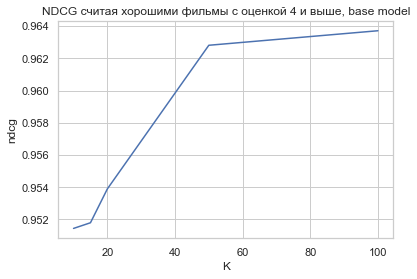

Wall time: 3min 3s


In [43]:
%%time
ndcgs = {}
for k in [10, 15, 20, 50, 100]:
    ndcg_base = evaluate_model_2(critics_train, critics_test,
                                   rec_func = getRecommendations,
                                   k = k)
    ndcgs[k]  = np.mean(list(ndcg_base.values()))

plt.figure()
plt.plot(list(ndcgs.keys()), list(ndcgs.values()))
plt.xlabel("K")
plt.ylabel("ndcg")
plt.title("NDCG считая хорошими фильмы с оценкой 4 и выше, base model")
plt.show()

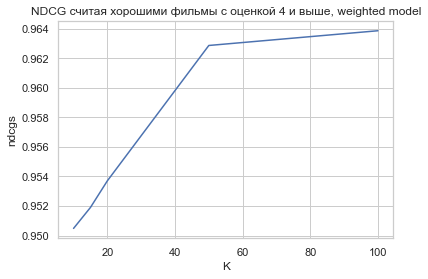

Wall time: 4min 7s


In [44]:
%%time
ndcgs = {}
for k in [10, 15, 20, 50, 100]:
    ndcg_weight = evaluate_model_2(critics_train, critics_test,
                                   rec_func = getRecommendations_weighted,
                                   k = k)
    ndcgs[k]  = np.mean(list(ndcg_weight.values()))

plt.figure()
plt.plot(list(ndcgs.keys()), list(ndcgs.values()))
plt.xlabel("K")
plt.ylabel("ndcgs")
plt.title("NDCG считая хорошими фильмы с оценкой 4 и выше, weighted model")
plt.show()

# Реализуте модель основанную на похожести предметов.

In [29]:
def transpose(dct):
    d = defaultdict(dict)
    for key1, inner in dct.items():
        for key2, value in inner.items():
            d[key2][key1] = value
    return dict(d)

In [30]:
critics_train_t = transpose(critics_train)
pd.DataFrame.from_dict(critics_train_t).head()

,One Flew Over the Cuckoo's Nest (1975),James and the Giant Peach (1996),My Fair Lady (1964),Erin Brockovich (2000),"Bug's Life, A (1998)","Princess Bride, The (1987)",Ben-Hur (1959),"Christmas Story, A (1983)",Snow White and the Seven Dwarfs (1937),"Wizard of Oz, The (1939)",...,Song of Freedom (1936),Nemesis 2: Nebula (1995),Smoking/No Smoking (1993),Brother Minister: The Assassination of Malcolm X (1994),Modulations (1998),"Crude Oasis, The (1995)",Master Ninja I (1984),Six Ways to Sunday (1997),One Little Indian (1973),"Five Wives, Three Secretaries and Me (1998)"
1,5.0,3.0,3.0,4.0,5.0,3.0,5.0,5.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,4.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,5.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,4.0,NaN,NaN,NaN,5.0,5.0,NaN,NaN,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
critics_test_t = transpose(critics_test)
pd.DataFrame.from_dict(critics_test_t).head()

,Donnie Brasco (1997),Gladiator (2000),Seven (Se7en) (1995),Apollo 13 (1995),"Usual Suspects, The (1995)","Thin Red Line, The (1998)",Ghostbusters (1984),Topsy-Turvy (1999),Go (1999),Fargo (1996),...,Tie Me Up! Tie Me Down! (1990),House of Dracula (1945),Withnail and I (1987),Manny & Lo (1996),Tales from the Crypt Presents: Bordello of Blood (1996),Mass Appeal (1984),Tough Guys (1986),Two if by Sea (1996),Lawnmower Man 2: Beyond Cyberspace (1996),From the Hip (1987)
5,3.0,2.0,3.0,2.0,5.0,5.0,3.0,5.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
620,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1035,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
%%time
rec1_t = getRecommendations(critics_train_t, critics_test_t, list(critics_test_t.keys())[0],
                          mode = "exact")
rec1_t

Wall time: 322 ms


{'5795': 1.0, '1685': 2.0}

In [33]:
%%time
errors_base_MAE_t,errors_base_RMSE_t =  evaluate_model(critics_train_t, critics_test_t,
                                                   rec_func = getRecommendations)

errors_clear_MAE = {k: errors_base_MAE_t[k] for k in errors_base_MAE_t if not isnan(errors_base_MAE_t[k])}
errors_clear_RMSE = {k: errors_base_RMSE_t[k] for k in errors_base_RMSE_t if not isnan(errors_base_RMSE_t[k])}

print("mean error for base-level model:")
print(np.mean(list(errors_clear_MAE.values())))
print("mean error for base-level model:")
print(np.mean(list(errors_clear_RMSE.values())))

C:\Users\wirze\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\wirze\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean error for base-level model:
0.8516664701481446
mean error for base-level model:
0.8902408968415594
Wall time: 7min 48s


In [34]:
%%time
errors_weighted_MAE_t,errors_weighted_RMSE_t =  evaluate_model(critics_train_t, critics_test_t,
                                                       rec_func = getRecommendations_weighted)

errors_clear_MAE = {k: errors_weighted_MAE_t[k] for k in errors_weighted_MAE_t if not isnan(errors_weighted_MAE_t[k])}
errors_clear_RMSE = {k: errors_weighted_RMSE_t[k] for k in errors_weighted_RMSE_t if not isnan(errors_weighted_RMSE_t[k])}

print("mean error for base-level model:")
print(np.mean(list(errors_clear_MAE.values())))
print("mean error for base-level model:")
print(np.mean(list(errors_clear_RMSE.values())))

C:\Users\wirze\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\wirze\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean error for base-level model:
0.714825428490486
mean error for base-level model:
0.7393833135370701
Wall time: 7min 57s


In [35]:
df_errors_1_t = pd.DataFrame(
    {'value': [*list(errors_base_MAE_t.values()),
               *list(errors_base_RMSE_t.values()),
               *list(errors_weighted_MAE_t.values()),
               *list(errors_weighted_RMSE_t.values())],
     'metric': [*np.repeat("MAE", len(errors_base_MAE_t.values()), axis=0),
                *np.repeat("RMSE", len(errors_base_RMSE_t.values()), axis=0),
                *np.repeat("MAE", len(errors_weighted_MAE_t.values()), axis=0),
                *np.repeat("RMSE", len(errors_weighted_RMSE_t.values()), axis=0)],
     'Model': [*np.repeat("base", len(errors_base_MAE_t.values()), axis=0),
               *np.repeat("base", len(errors_base_RMSE_t.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_MAE_t.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_RMSE_t.values()), axis=0)]}
)
df_errors_1_t.tail()

,value,metric,Model
10727,NaN,RMSE,weighted
10728,NaN,RMSE,weighted
10729,NaN,RMSE,weighted
10730,NaN,RMSE,weighted
10731,0.544157,RMSE,weighted


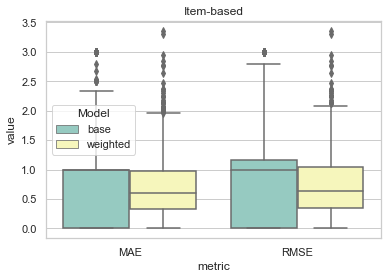

In [36]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="metric", y="value", hue="Model",
                 data=df_errors_1_t, palette="Set3")
ax.set_title("Item-based")
plt.show()

it looks like item-based models won't work in 25% cases at all
so maybe I need a better implementation
I also did not filtered out rare movies,so they might make mi life worse
in general weighted model shows better results with smaller error size

In [37]:
%%time
df_test = pd.DataFrame.from_dict(critics_test)
df_test = df_test.replace(np.nan, 0)
df_test

Wall time: 342 ms


,5,10,15,20,25,30,35,40,45,50,...,5995,6000,6005,6010,6015,6020,6025,6030,6035,6040
Donnie Brasco (1997),3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gladiator (2000),2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Seven (Se7en) (1995),3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Apollo 13 (1995),2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Usual Suspects, The (1995)",5.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mass Appeal (1984),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tough Guys (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
Two if by Sea (1996),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
Lawnmower Man 2: Beyond Cyberspace (1996),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [38]:
%%time
df_train = pd.DataFrame.from_dict(critics_train).replace(np.nan, 0)
df_train

Wall time: 2.19 s


,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
One Flew Over the Cuckoo's Nest (1975),5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,5.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0
James and the Giant Peach (1996),3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
My Fair Lady (1964),3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0
Erin Brockovich (2000),4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
"Bug's Life, A (1998)",5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Crude Oasis, The (1995)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Master Ninja I (1984),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Six Ways to Sunday (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
One Little Indian (1973),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
%%time
knn = NearestNeighbors(metric='cosine', algorithm='auto', n_jobs = -1)
knn.fit(df_train.values)

distances_t, indices_t = knn.kneighbors(df_train.values, n_neighbors=40)

Wall time: 3.31 s


In [40]:
def topMatches_item(prefs, person, distances, indices, scale = False):
    user = list(prefs.keys()).index(person)
    keys = [list(prefs)[i] for i in indices[user][1:].tolist()]
    if scale:
        values = min(distances[user][1:])/(distances[user][1:])
    else:
        values = 1-(distances[user][1:])
    dictionary = sorted(list(zip(values, keys)), reverse=True)
    return dictionary

In [41]:
%%time
temp_ = topMatches_item(critics_train_t,
                        list(critics_test_t.keys())[2],
                        distances_t, indices_t)
temp_

Wall time: 0 ns


[(0.5961542767350019, 'Usual Suspects, The (1995)'),
 (0.5841182007562972, 'Reservoir Dogs (1992)'),
 (0.5417308038189989, 'Silence of the Lambs, The (1991)'),
 (0.5413189766170677, 'Pulp Fiction (1994)'),
 (0.5331062915165311, 'Fargo (1996)'),
 (0.5164582465469002, 'Heat (1995)'),
 (0.5113762459174296, 'Sixth Sense, The (1999)'),
 (0.508682800274364, 'Fugitive, The (1993)'),
 (0.5065643248091806, 'L.A. Confidential (1997)'),
 (0.5021716316168202, 'Game, The (1997)'),
 (0.4956148275294373, 'Matrix, The (1999)'),
 (0.4927984773218199, 'Simple Plan, A (1998)'),
 (0.488679562096326, 'Few Good Men, A (1992)'),
 (0.48638363978500654,
  'Professional, The (a.k.a. Leon: The Professional) (1994)'),
 (0.48346219218884623, 'Terminator 2: Judgment Day (1991)'),
 (0.4822234639623133, 'Shawshank Redemption, The (1994)'),
 (0.478749165194839, 'GoodFellas (1990)'),
 (0.47848286937536266, "Devil's Advocate, The (1997)"),
 (0.4750420507332418, 'Jackie Brown (1997)'),
 (0.4737914261115055, 'Twelve Monke

In [42]:
# Получить рекомендации для заданного человека, пользуясь взвешенным средним
# оценок, данных всеми остальными пользователями
def getRecommendations_item(prefs, test,person,
                            distances  = distances_t, indices = indices_t,
                       mode = "exact"):
    top_persons = topMatches_item(prefs,person, distances, indices)
    film_sum = {}
    film_multiplyer = {}
    for p in top_persons:
        if p[0] <= 0:
            break
        if mode != "exact":
            for movie in prefs[p[1]]:
                if not movie in film_sum:
                    film_sum[movie] = 0
                    film_multiplyer[movie] = 0

                film_sum[movie] += prefs[p[1]][movie]*p[0]
                film_multiplyer[movie] += p[0]
        if mode == "exact":
            test_list = test[person]
            for movie in prefs[p[1]]:
                if movie in test_list:
                    if not movie in film_sum:
                        film_sum[movie] = 0
                        film_multiplyer[movie] = 0

                    film_sum[movie] += prefs[p[1]][movie]*p[0]
                    film_multiplyer[movie] += p[0]

    if mode == "only_NA":
        recomend = sorted([(movie, film_sum[movie]/film_multiplyer[movie]) for movie in film_sum if movie not in prefs[person]], reverse = True)
    elif mode == "all":
        recomend = sorted([(movie, film_sum[movie]/film_multiplyer[movie]) for movie in film_sum], reverse = True)
    elif mode == "exact":
        recomend = sorted([(movie, film_sum[movie]/film_multiplyer[movie]) for movie in film_sum if movie in test_list], reverse = True)

    return dict(recomend)

In [43]:
%%time

df_transp = pd.DataFrame.from_dict(critics_train).replace(np.nan, 0)

knn = NearestNeighbors(metric='cosine', algorithm='auto', n_jobs = -1)
knn.fit(df_transp.values)

distances_t, indices_t = knn.kneighbors(df_transp.values, n_neighbors=100)

Wall time: 4.5 s


In [44]:
%%time
rec1_t = getRecommendations_item(critics_train_t, critics_test_t, list(critics_test_t.keys())[0],
                                 distances_t, indices_t,
                            mode = "exact")
rec1_t

Wall time: 0 ns


{'620': 4.284719239209713,
 '5795': 4.456792806020311,
 '5390': 4.0,
 '5': 3.7002173657598836,
 '4605': 4.43322358289772,
 '4235': 4.0,
 '3880': 5.0,
 '3685': 4.350836551247079,
 '3475': 3.392885593730333,
 '3430': 3.7310871313523655,
 '3250': 2.7920929058776807,
 '2900': 5.0,
 '2020': 3.4029579568754516,
 '1890': 4.0,
 '1685': 3.0,
 '15': 3.3450388091073764,
 '1010': 3.6759891549941845}

In [45]:
def getRecommendations_weighted_item(prefs, test, person,
                                     distances = distances_t, indices = indices_t,
                                mode = "exact"):
    '''
    :param prefs: train df
    :param person: test df
    :param distances: distance matrix
    :param indices: index matrix
    :param test_list: list of items to predict
    :return: dict with movies and ratings
    '''
    top_persons = topMatches_item(prefs,person, distances, indices)
    test_list = test[person]
    film_sum = {}
    film_multiplyer = {}
    # user 1 average
    person_mean = np.mean(list(prefs[person].values()))
    for p in top_persons:
        # user_ratings = []
        user_ratings_2 = {}
        # берём только от похожих
        if p[0] <= 0.5:
            break
        for movie in prefs[p[1]]:
            ## считаем среднюю оценку и стандартное отклонение других пользователей
            # user_ratings.append(prefs[p[1]][movie])
            user_ratings_2[movie] = prefs[p[1]][movie]
            if mode == "exact":
                if movie in test_list:
                    if not movie in film_sum:
                        film_sum[movie] = 0
                        film_multiplyer[movie] = 0

                    ### типа з скор что-ли
                    film_sum[movie] += p[0] * (prefs[p[1]][movie] - np.array(list(user_ratings_2.values())).mean()) / (np.array(list(user_ratings_2.values())).std() + 0.000000000001)
                    film_multiplyer[movie] += p[0]
            if mode == "only_NA":
                if not movie in film_sum:
                    film_sum[movie] = 0
                    film_multiplyer[movie] = 0
                    ### типа з скор что-ли
                film_sum[movie] += p[0] * (prefs[p[1]][movie] - np.array(list(user_ratings_2.values())).mean()) / (np.array(list(user_ratings_2.values())).std() + 0.000000000001)
                film_multiplyer[movie] += p[0]
    ## добавляем среднюю оценку изначального пользователя
    if mode == "exact":
        recomend = sorted([(movie, person_mean + film_sum[movie]/film_multiplyer[movie]) for movie in film_sum], reverse = True)
    if mode == "only_NA":
        recomend = sorted([(movie, person_mean + film_sum[movie]/film_multiplyer[movie]) for movie in film_sum if movie not in prefs[person]], reverse = True)
    return dict(recomend)

In [46]:
%%time
rec2_t = getRecommendations_weighted_item(critics_train_t, critics_test_t,
                                          list(critics_test_t.keys())[0],
                                 distances_t, indices_t,
                                 mode = "exact")
rec2_t

Wall time: 0 ns


{}

### MAE RMSE

In [47]:
%%time
errors_base_MAE_t_2,errors_base_RMSE_t_2 =  evaluate_model(critics_train_t, critics_test_t,
                                                       rec_func = getRecommendations_item)

errors_clear_MAE = {k: errors_base_MAE_t_2[k] for k in errors_base_MAE_t_2 if not isnan(errors_base_MAE_t_2[k])}
errors_clear_RMSE = {k: errors_base_RMSE_t_2[k] for k in errors_base_RMSE_t_2 if not isnan(errors_base_RMSE_t_2[k])}

print("mean error for base-level model:")
print(np.mean(list(errors_clear_MAE.values())))
print("mean error for base-level model:")
print(np.mean(list(errors_clear_RMSE.values())))

C:\Users\wirze\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\wirze\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean error for base-level model:
0.8432705124830293
mean error for base-level model:
0.9979342156136465
Wall time: 5.1 s


In [48]:
%%time
errors_weighted_MAE_t_2, errors_weighted_RMSE_t_2 = evaluate_model(critics_train_t, critics_test_t, rec_func = getRecommendations_weighted_item)

errors_clear_MAE = {k: errors_weighted_MAE_t_2[k] for k in errors_weighted_MAE_t_2 if not isnan(errors_weighted_MAE_t_2[k])}
errors_clear_RMSE = {k: errors_weighted_RMSE_t_2[k] for k in errors_weighted_RMSE_t_2 if not isnan(errors_weighted_RMSE_t_2[k])}

print("mean error for base-level model:")
print(np.mean(list(errors_clear_MAE.values())))
print("mean error for base-level model:")
print(np.mean(list(errors_clear_RMSE.values())))

C:\Users\wirze\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\wirze\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean error for base-level model:
0.7823897148468355
mean error for base-level model:
0.9258365269169926
Wall time: 10 s


In [49]:
df_errors_2_t = pd.DataFrame(
    {'value': [*list(errors_base_MAE_t_2.values()),
               *list(errors_base_RMSE_t_2.values()),
               *list(errors_weighted_MAE_t_2.values()),
               *list(errors_weighted_RMSE_t_2.values())],
     'metric': [*np.repeat("MAE", len(errors_base_MAE_t_2.values()), axis=0),
                *np.repeat("RMSE", len(errors_base_RMSE_t_2.values()), axis=0),
                *np.repeat("MAE", len(errors_weighted_MAE_t_2.values()), axis=0),
                *np.repeat("RMSE", len(errors_weighted_RMSE_t_2.values()), axis=0)],
     'Model': [*np.repeat("base", len(errors_base_MAE_t_2.values()), axis=0),
               *np.repeat("base", len(errors_base_RMSE_t_2.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_MAE_t_2.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_RMSE_t_2.values()), axis=0)]}
)
df_errors_2_t

,value,metric,Model
0,0.760935,MAE,base
1,0.754401,MAE,base
2,0.704783,MAE,base
3,0.730010,MAE,base
4,0.746405,MAE,base
...,...,...,...
10727,NaN,RMSE,weighted
10728,NaN,RMSE,weighted
10729,NaN,RMSE,weighted
10730,NaN,RMSE,weighted


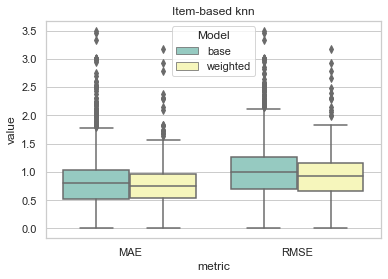

In [50]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="metric", y="value", hue="Model",
                 data=df_errors_2_t, palette="Set3")
ax.set_title("Item-based knn")
plt.show()

In [51]:
df_errors_1_t['model_item'] = "asis"
df_errors_2_t['model_item'] = "knn"
df_errors_all_t = pd.concat([df_errors_1_t, df_errors_2_t])
df_errors_all_t

,value,metric,Model,model_item
0,2.0,MAE,base,asis
1,3.0,MAE,base,asis
2,NaN,MAE,base,asis
3,2.0,MAE,base,asis
4,1.0,MAE,base,asis
...,...,...,...,...
10727,NaN,RMSE,weighted,knn
10728,NaN,RMSE,weighted,knn
10729,NaN,RMSE,weighted,knn
10730,NaN,RMSE,weighted,knn


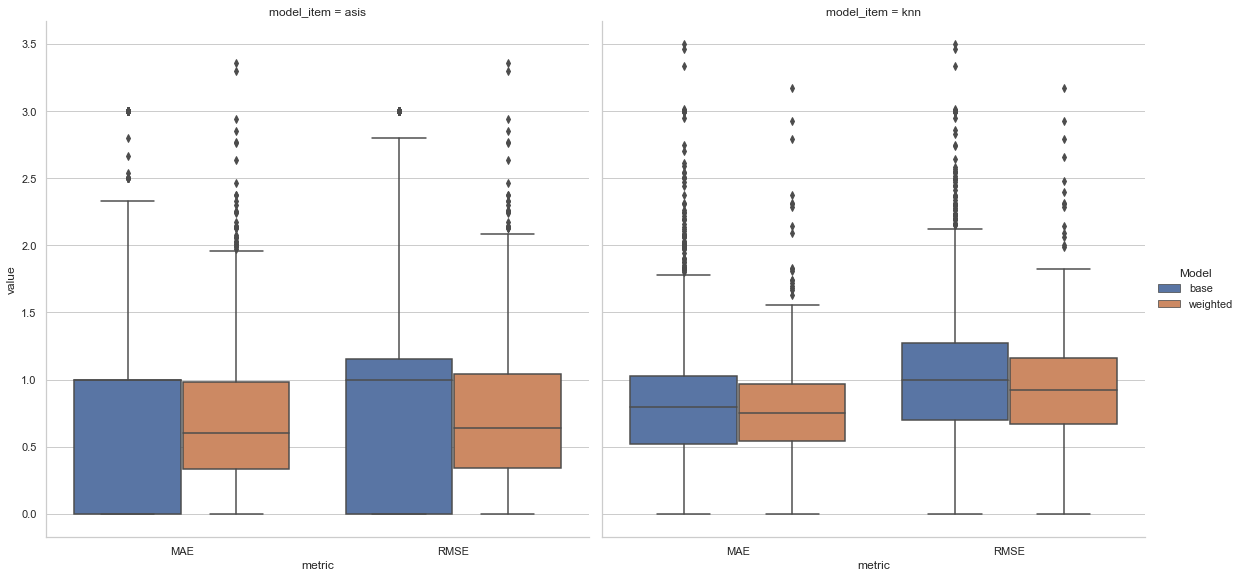

In [52]:
g = sns.catplot(x="metric", y="value", hue="Model",
                col="model_item",
                data=df_errors_all_t, kind="box",
                height=8, aspect=1)

ошибка в среднем ухудшилась на 0.3, но базовая модель перестала так яасто выдавать наны, теперь оценка честнее

однако если учитывать, что модель as is считалась минут 20, то схожеть на knn со всего 100 соседями даёт колосальную вычеслительное преимущество

наверное

хочу попробовать большой датасет

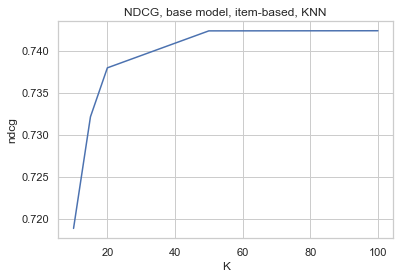

Wall time: 26.9 s


In [60]:
%%time
ndcgs = {}
for k in [10, 15, 20, 50, 100]:
    ndcg_base_t = evaluate_model_2(critics_train_t, critics_test_t,
                                 rec_func = getRecommendations_item,
                                 k = k)
    ndcgs[k]  = np.mean(list(ndcg_base_t.values()))

plt.figure()
plt.plot(list(ndcgs.keys()), list(ndcgs.values()))
plt.xlabel("K")
plt.ylabel("ndcg")
plt.title("NDCG, base model, item-based, KNN")
plt.show()

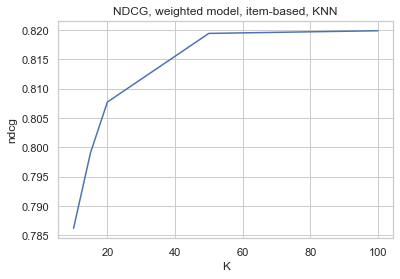

Wall time: 47.7 s


In [461]:
%%time
ndcgs = {}
for k in [10, 15, 20, 50, 100]:
    ndcg_weight_t = evaluate_model_2(critics_train_t, critics_test_t,
                                   rec_func = getRecommendations_weighted_item,
                                   k = k)
    ndcgs[k]  = np.mean(list(ndcg_weight_t.values()))

plt.figure()
plt.plot(list(ndcgs.keys()), list(ndcgs.values()))
plt.xlabel("K")
plt.ylabel("ndcg")
plt.title("NDCG, weighted model, item-based, KNN")
plt.show()

# LARGER DATASET

In [ ]:
#Чтение данных
def loadMovieLens10M(path='./ml-1m'):
    # Получить названия фильмов
    movies={}
    for line in open(path+'/movies.dat', encoding="utf-8"):
        (id,title)=line.split('::')[0:2] #при желании тут можно добавить чтение жанров.
        movies[id]=title
    # Загрузить данные
    prefs={}
    for line in open(path+'/ratings.dat', encoding="utf-8"):
        (user,movieid,rating,ts)=line.split('::')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
    return prefs

In [18]:
critics_10 = loadMovieLens10M(path='./ml-10M100K')

In [19]:
all_users_10 = [u for u in critics_10]
print(len(all_users_10))
users_test_list_10 = [u for u in critics_10 if int(u) % 5 == 0]
print(len(users_test_list_10))

69878
13978


In [20]:
critics_test_10 = {}
for u in users_test_list_10:
    critics_test_10[u] = {}
    m_id = 0
    for m in critics_10[u]:
        m_id += 1
        if m_id % 10 == 0:
            critics_test_10[u][m] = critics_10[u][m]
        # else:
        #     critics_train[u][m] = critics[u][m]

In [21]:
critics_train_10 = {}
for u in all_users_10:
    if u not in users_test_list_10:
        critics_train_10[u] = {}
        for m in critics_10[u]:
            critics_train_10[u][m] = critics_10[u][m]
    else:
        critics_train_10[u] = {}
        m_id = 0
        for m in critics_10[u]:
            m_id += 1
            if m_id % 10 == 0:
                critics_train_10[u][m] = critics_10[u][m]

здесь чисто питон жрёт 1 гиг оперативки
## user-based

In [ ]:
%%time
errors_base_MAE_10,errors_base_RMSE_10 =  evaluate_model(critics_train_10, critics_test_10,
                                                   rec_func = getRecommendations)

errors_clear_MAE = {k: errors_base_MAE_10[k] for k in errors_base_MAE_10 if not isnan(errors_base_MAE_10[k])}
errors_clear_RMSE = {k: errors_base_RMSE_10[k] for k in errors_base_RMSE_10 if not isnan(errors_base_RMSE_10[k])}

print("mean error for base-level model:")
print(np.mean(list(errors_clear_MAE.values())))
print("mean error for base-level model:")
print(np.mean(list(errors_clear_RMSE.values())))

C:\Users\wirze\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\wirze\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
%%time
errors_weighted_MAE_10,errors_weighted_RMSE_10 = evaluate_model(critics_train_10, critics_test_10,
                                                          rec_func = getRecommendations_weighted)

errors_clear_MAE = {k: errors_weighted_MAE_10[k] for k in errors_weighted_MAE_10
                    if not isnan(errors_weighted_MAE_10[k])}
errors_clear_RMSE = {k: errors_weighted_RMSE_10[k] for k in errors_weighted_RMSE_10
                     if not isnan(errors_weighted_RMSE_10[k])}

print("mean error for z-score model:")
print(np.mean(list(errors_clear_MAE.values())))
print("RMSE for z-score model:")
print(np.mean(list(errors_clear_RMSE.values())))

In [ ]:
df_errors_10 = pd.DataFrame(
    {'value': [*list(errors_base_MAE_10.values()),
               *list(errors_base_RMSE_10.values()),
               *list(errors_weighted_MAE_10.values()),
               *list(errors_weighted_RMSE_10.values())],
     'metric': [*np.repeat("MAE", len(errors_base_MAE_10.values()), axis=0),
                *np.repeat("RMSE", len(errors_base_RMSE_10.values()), axis=0),
                *np.repeat("MAE", len(errors_weighted_MAE_10.values()), axis=0),
                *np.repeat("RMSE", len(errors_weighted_RMSE_10.values()), axis=0)],
     'Model': [*np.repeat("base", len(errors_base_MAE_10.values()), axis=0),
               *np.repeat("base", len(errors_base_RMSE_10.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_MAE_10.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_RMSE_10.values()), axis=0)]}
)

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="metric", y="value", hue="Model",
                 data=df_errors_10, palette="Set3")

## item based

In [22]:
critics_train_t10 = transpose(critics_train_10)
critics_test_t10 = transpose(critics_test_10)

здесь ушло ещё пол гига оперативной памяти

In [23]:
%%time

df_transp10 = pd.DataFrame.from_dict(critics_train_10).replace(np.nan, 0)

knn_10 = NearestNeighbors(metric='cosine', algorithm='auto', n_jobs = -1)
knn_10.fit(df_transp10.values)

Wall time: 1min 22s


NearestNeighbors(metric='cosine', n_jobs=-1)

до 10 гигов забирало в пике

In [24]:
%%time
distances_t10, indices_t10 = knn_10.kneighbors(df_transp10.values, n_neighbors=20)

Wall time: 6min 14s


ну здесь уже сразу 12 гигов и 80% процессора  -- хранить матрицы расстояни не эффективное

In [25]:
# Получить рекомендации для заданного человека, пользуясь взвешенным средним
# оценок, данных всеми остальными пользователями
def getRecommendations_item10(prefs, test,person,
                            distances  = distances_t10, indices = indices_t10,
                            mode = "exact"):
    top_persons = topMatches_item(prefs,person, distances, indices)
    film_sum = {}
    film_multiplyer = {}
    for p in top_persons:
        if p[0] <= 0:
            break
        if mode != "exact":
            for movie in prefs[p[1]]:
                if not movie in film_sum:
                    film_sum[movie] = 0
                    film_multiplyer[movie] = 0

                film_sum[movie] += prefs[p[1]][movie]*p[0]
                film_multiplyer[movie] += p[0]
        if mode == "exact":
            test_list = test[person]
            for movie in prefs[p[1]]:
                if movie in test_list:
                    if not movie in film_sum:
                        film_sum[movie] = 0
                        film_multiplyer[movie] = 0

                    film_sum[movie] += prefs[p[1]][movie]*p[0]
                    film_multiplyer[movie] += p[0]

    if mode == "only_NA":
        recomend = sorted([(movie, film_sum[movie]/film_multiplyer[movie]) for movie in film_sum if movie not in prefs[person]], reverse = True)
    elif mode == "all":
        recomend = sorted([(movie, film_sum[movie]/film_multiplyer[movie]) for movie in film_sum], reverse = True)
    elif mode == "exact":
        recomend = sorted([(movie, film_sum[movie]/film_multiplyer[movie]) for movie in film_sum if movie in test_list], reverse = True)

    return dict(recomend)

In [26]:
def getRecommendations_weighted_item10(prefs, test, person,
                                     distances = distances_t10, indices = indices_t10,
                                     mode = "exact"):
    '''
    :param prefs: train df
    :param person: test df
    :param distances: distance matrix
    :param indices: index matrix
    :param test_list: list of items to predict
    :return: dict with movies and ratings
    '''
    top_persons = topMatches_item(prefs,person, distances, indices)
    test_list = test[person]
    film_sum = {}
    film_multiplyer = {}
    # user 1 average
    person_mean = np.mean(list(prefs[person].values()))
    for p in top_persons:
        user_ratings_2 = {}
        if p[0] <= 0.5:
            break
        for movie in prefs[p[1]]:
            user_ratings_2[movie] = prefs[p[1]][movie]
            if mode == "exact":
                if movie in test_list:
                    if not movie in film_sum:
                        film_sum[movie] = 0
                        film_multiplyer[movie] = 0

                    ### типа з скор что-ли
                    film_sum[movie] += p[0] * (prefs[p[1]][movie] - np.array(list(user_ratings_2.values())).mean()) / (np.array(list(user_ratings_2.values())).std() + 0.000000000001)
                    film_multiplyer[movie] += p[0]
            if mode == "only_NA":
                if not movie in film_sum:
                    film_sum[movie] = 0
                    film_multiplyer[movie] = 0
                    ### типа з скор что-ли
                film_sum[movie] += p[0] * (prefs[p[1]][movie] - np.array(list(user_ratings_2.values())).mean()) / (np.array(list(user_ratings_2.values())).std() + 0.000000000001)
                film_multiplyer[movie] += p[0]
    ## добавляем среднюю оценку изначального пользователя
    if mode == "exact":
        recomend = sorted([(movie, person_mean + film_sum[movie]/film_multiplyer[movie]) for movie in film_sum], reverse = True)
    if mode == "only_NA":
        recomend = sorted([(movie, person_mean + film_sum[movie]/film_multiplyer[movie]) for movie in film_sum if movie not in prefs[person]], reverse = True)
    return dict(recomend)

In [27]:
%%time
errors_base_MAE_t10, errors_base_RMSE_t10 = evaluate_model(critics_train_t10, critics_test_t10,
                                                           rec_func=getRecommendations_item10)

errors_clear_MAE = {k: errors_base_MAE_t10[k] for k in errors_base_MAE_t10 if not isnan(errors_base_MAE_t10[k])}
errors_clear_RMSE = {k: errors_base_RMSE_t10[k] for k in errors_base_RMSE_t10 if not isnan(errors_base_RMSE_t10[k])}

print("mean error for base-level model:")
print(np.mean(list(errors_clear_MAE.values())))
print("mean error for base-level model:")
print(np.mean(list(errors_clear_RMSE.values())))

C:\Users\wirze\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\wirze\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean error for base-level model:
0.7464749712093377
mean error for base-level model:
0.9082539750496396
Wall time: 41.6 s


In [28]:
%%time
errors_weighted_MAE_t10, errors_weighted_RMSE_t10 = evaluate_model(critics_train_t10, critics_test_t10,
                                                                   rec_func=getRecommendations_weighted_item10)

errors_clear_MAE = {k: errors_weighted_MAE_t10[k] for k in errors_weighted_MAE_t10 if
                    not isnan(errors_weighted_MAE_t10[k])}
errors_clear_RMSE = {k: errors_weighted_RMSE_t10[k] for k in errors_weighted_RMSE_t10 if
                     not isnan(errors_weighted_RMSE_t10[k])}

print("mean error for base-level model:")
print(np.mean(list(errors_clear_MAE.values())))
print("mean error for base-level model:")
print(np.mean(list(errors_clear_RMSE.values())))

mean error for base-level model:
0.7412856576337493
mean error for base-level model:
0.9215029275637271
Wall time: 1min 16s


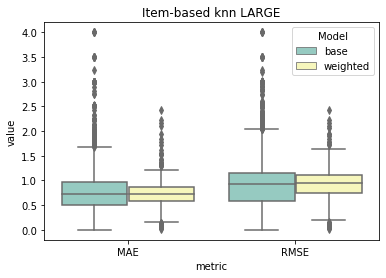

In [29]:
df_errors_2_t10 = pd.DataFrame(
    {'value': [*list(errors_base_MAE_t10.values()),
               *list(errors_base_RMSE_t10.values()),
               *list(errors_weighted_MAE_t10.values()),
               *list(errors_weighted_RMSE_t10.values())],
     'metric': [*np.repeat("MAE", len(errors_base_MAE_t10.values()), axis=0),
                *np.repeat("RMSE", len(errors_base_RMSE_t10.values()), axis=0),
                *np.repeat("MAE", len(errors_weighted_MAE_t10.values()), axis=0),
                *np.repeat("RMSE", len(errors_weighted_RMSE_t10.values()), axis=0)],
     'Model': [*np.repeat("base", len(errors_base_MAE_t10.values()), axis=0),
               *np.repeat("base", len(errors_base_RMSE_t10.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_MAE_t10.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_RMSE_t10.values()), axis=0)]}
)

ax = sns.boxplot(x="metric", y="value", hue="Model",
                 data=df_errors_2_t10, palette="Set3")
ax.set_title("Item-based knn LARGE")
plt.show()

так, тут я умываю руки, оно запустилось, вышло за оперативку и кое как ошибается меньше чем на балл, но зато считается быстро, а обучается долго
взвешенная модель настолько же плохая, но у неё меньше дисперсия

# $\beta$

Попробуйте улучшить результаты подбором $\beta$ для минимизации MAE (RMSE) в гибридных рекомендациях: $$\beta\cdot r{user-based}_{ui} + (1-\beta)\cdot r{item-based}_{ui}, \mbox{ где } 0 \leq \beta \leq 1.$$

In [62]:
df_errors_1

,value,metric,Model
0,0.638064,MAE,base
1,0.710178,MAE,base
2,0.447585,MAE,base
3,NaN,MAE,base
4,0.408339,MAE,base
...,...,...,...
4827,0.528545,RMSE,weighted
4828,0.983850,RMSE,weighted
4829,0.752316,RMSE,weighted
4830,1.270042,RMSE,weighted


In [61]:
df_errors_1_t

,value,metric,Model,model_item
0,2.000000,MAE,base,asis
1,3.000000,MAE,base,asis
2,NaN,MAE,base,asis
3,2.000000,MAE,base,asis
4,1.000000,MAE,base,asis
...,...,...,...,...
10727,NaN,RMSE,weighted,asis
10728,NaN,RMSE,weighted,asis
10729,NaN,RMSE,weighted,asis
10730,NaN,RMSE,weighted,asis


In [65]:
def get_recommend(train, test, rec_func):
    recommendations_w_t = {}
    for m in test:
        recommendations_w_t[m] = rec_func(train, test,
                 m)
    return recommendations_w_t

In [66]:
%%time
recs_w_t = get_recommend(critics_train_t, critics_test_t, getRecommendations_weighted_item)

Wall time: 9.78 s


In [67]:
%%time
recs_w = get_recommend(critics_train, critics_test, getRecommendations_weighted)

Wall time: 48.7 s


In [69]:
recs_w

{'5': {'Waiting for Guffman (1996)': 4.196731327735127,
  'Usual Suspects, The (1995)': 4.601435206217499,
  'Topsy-Turvy (1999)': 4.0065375595393675,
  'Thin Red Line, The (1998)': 4.53480319884542,
  'Seven (Se7en) (1995)': 2.888631431965551,
  'Rosencrantz and Guildenstern Are Dead (1990)': 3.8101824996431777,
  'Much Ado About Nothing (1993)': 3.5542943591344516,
  "Jacob's Ladder (1990)": 3.3075437809986834,
  'Incredibly True Adventure of Two Girls in Love, The (1995)': 2.9411764528265527,
  'In the Company of Men (1997)': 1.610337710730162,
  'Go (1999)': 4.436241320652719,
  'Gladiator (2000)': 3.1317565005961256,
  'Ghostbusters (1984)': 3.271733855221163,
  'Fight Club (1999)': 4.437459199767562,
  'Fast, Cheap & Out of Control (1997)': 3.8463453552303033,
  'Fargo (1996)': 4.00162637114171,
  'Donnie Brasco (1997)': 3.053393116308754,
  'Bullets Over Broadway (1994)': 3.972061272878178,
  'Apollo 13 (1995)': 3.3357939770552236},
 '10': {'While You Were Sleeping (1995)': 4.60

In [70]:
recs_w_t = transpose(recs_w_t)
recs_w_t

{'90': {'Gladiator (2000)': 3.878646158591753,
  'Braveheart (1995)': 5.098522266015779,
  'Shawshank Redemption, The (1994)': 3.679775665584565,
  'Mission: Impossible 2 (2000)': 4.038945411829985,
  'Good Will Hunting (1997)': 5.056909593583115},
 '5475': {'Gladiator (2000)': 3.764989066057435,
  'Ghostbusters (1984)': 3.3051399966879496,
  'Lethal Weapon (1987)': 3.835638106297654,
  'Abyss, The (1989)': 3.431734249458124,
  'Back to the Future (1985)': 3.343906153033296,
  'Matrix, The (1999)': 3.315704547800828,
  'Taxi Driver (1976)': 4.998849884550058,
  'Chinatown (1974)': 5.261452647689824,
  'Star Trek IV: The Voyage Home (1986)': 2.6617420640367224,
  'Superman II (1980)': 3.5536859556328566,
  'Blues Brothers, The (1980)': 3.259941628213911},
 '5360': {'Gladiator (2000)': 4.852151260099164,
  'Mission: Impossible 2 (2000)': 1.9992831689479362},
 '445': {'Gladiator (2000)': 3.3366182920185956,
  'Star Trek: Generations (1994)': 2.7303812809667773,
  'Star Trek III: The Searc

In [72]:
len(recs_w_t)

663

In [80]:
users_left  = [user for user in recs_w if user in recs_w_t]
len(users_left)

663

In [86]:
recs_w_clean = {}
for user in recs_w:
    if user in users_left:
        recs_w_clean[user] = recs_w[user]

In [87]:
recs_w_t_clean = {}
for user in recs_w_t:
    if user in users_left:
        recs_w_t_clean[user] = recs_w_t[user]

In [91]:
recs_w_t_clean

{'90': {'Gladiator (2000)': 3.878646158591753,
  'Braveheart (1995)': 5.098522266015779,
  'Shawshank Redemption, The (1994)': 3.679775665584565,
  'Mission: Impossible 2 (2000)': 4.038945411829985,
  'Good Will Hunting (1997)': 5.056909593583115},
 '5475': {'Gladiator (2000)': 3.764989066057435,
  'Ghostbusters (1984)': 3.3051399966879496,
  'Lethal Weapon (1987)': 3.835638106297654,
  'Abyss, The (1989)': 3.431734249458124,
  'Back to the Future (1985)': 3.343906153033296,
  'Matrix, The (1999)': 3.315704547800828,
  'Taxi Driver (1976)': 4.998849884550058,
  'Chinatown (1974)': 5.261452647689824,
  'Star Trek IV: The Voyage Home (1986)': 2.6617420640367224,
  'Superman II (1980)': 3.5536859556328566,
  'Blues Brothers, The (1980)': 3.259941628213911},
 '5360': {'Gladiator (2000)': 4.852151260099164,
  'Mission: Impossible 2 (2000)': 1.9992831689479362},
 '445': {'Gladiator (2000)': 3.3366182920185956,
  'Star Trek: Generations (1994)': 2.7303812809667773,
  'Star Trek III: The Searc

In [104]:
critics_test_clear = {}
for user in critics_test:
    if user in users_left:
        critics_test_clear[user] = critics_test[user]

In [105]:
df_real = pd.DataFrame.from_dict(critics_test_clear)
df_real = df_real.reindex(sorted(df_real.columns), axis=1).sort_index()
df_real = df_real.reset_index()
df_real

,index,10,100,1000,1010,1015,1020,1030,1040,105,...,935,940,945,95,955,965,970,975,985,990
0,'Night Mother (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"'burbs, The (1989)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,...And Justice for All (1979),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
4,10 Things I Hate About You (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562,Your Friends and Neighbors (1998),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2563,"Zed & Two Noughts, A (1985)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2564,Zero Effect (1998),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
2565,Zeus and Roxanne (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
df_user_rec = pd.DataFrame.from_dict(recs_w_clean)
df_user_rec = df_user_rec.reindex(sorted(df_user_rec.columns), axis=1).sort_index()
df_user_rec = df_user_rec.reset_index()
df_user_rec

,index,10,100,1000,1010,1015,1020,1030,1040,105,...,935,940,945,95,955,965,970,975,985,990
0,'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"'burbs, The (1989)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,...And Justice for All (1979),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10 Things I Hate About You (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.925159,NaN,NaN,NaN,NaN,NaN,NaN
4,101 Dalmatians (1961),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,Young Guns (1988),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1940,Young Guns II (1990),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1941,Young Sherlock Holmes (1985),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1942,Zero Effect (1998),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
df_item_rec = pd.DataFrame.from_dict(recs_w_t_clean)
df_item_rec = df_item_rec.reindex(sorted(df_item_rec.columns), axis=1).sort_index()
df_item_rec = df_item_rec.reset_index()
df_item_rec

,index,10,100,1000,1010,1015,1020,1030,1040,105,...,935,940,945,95,955,965,970,975,985,990
0,101 Dalmatians (1961),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001: A Space Odyssey (1968),4.08292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Abyss, The (1989)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.907493,NaN,NaN,NaN,NaN,NaN
3,Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ace Ventura: When Nature Calls (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,"World Is Not Enough, The (1999)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,"Wrong Trousers, The (1993)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,"X-Files: Fight the Future, The (1998)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404,You've Got Mail (1998),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.821824,NaN,NaN,NaN


In [111]:
def evaluate_beta(beta = 0.5):
    errors_beta = 0
    for user in critics_test_clear:
        for movie in critics_test_clear[user]:
            if movie in recs_w_clean[user]:
                if movie in recs_w_t_clean[user]:
                    errors_beta += abs(recs_w_clean[user][movie] * beta + recs_w_t_clean[user][movie] * (1-beta) - critics_test_clear[user][movie])
    return errors_beta

In [112]:
evaluate_beta()

1922.0834225755866

In [130]:
beta_results = {}
for b in np.arange(0.0, 1.1, 0.025):
    beta_results[b] = evaluate_beta(beta = b)

In [132]:
beta_results_df  = pd.DataFrame.from_records(beta_results, index  = [2])
beta_results_df

,0.000,0.025,0.050,0.075,0.100,0.125,0.150,0.175,0.200,0.225,...,0.850,0.875,0.900,0.925,0.950,0.975,1.000,1.025,1.050,1.075
2,2856.579176,2798.005784,2740.466754,2684.019535,2628.511748,2573.949579,2520.440076,2468.111629,2416.674633,2366.567078,...,1740.575339,1749.437333,1760.534727,1774.207412,1790.254975,1809.137279,1830.435125,1853.719658,1879.601614,1908.056985


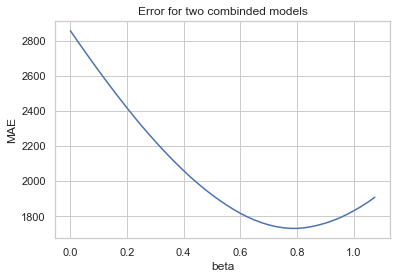

In [133]:
plt.figure()
plt.plot(list(beta_results.keys()), list(beta_results.values()))
plt.xlabel("beta")
plt.ylabel("MAE")
plt.title("Error for two combinded models")
plt.show()

In [134]:
def evaluate_beta(beta = 0.5):
    errors_beta = 0
    for user in critics_test_clear:
        for movie in critics_test_clear[user]:
            if movie in recs_w_clean[user]:
                if movie in recs_w_t_clean[user]:
                    errors_beta += sqrt((recs_w_clean[user][movie] * beta + recs_w_t_clean[user][movie] * (1-beta) - critics_test_clear[user][movie])**2)
    return errors_beta

In [135]:
beta_results_rmse = {}
for b in np.arange(0.0, 1.05, 0.025):
    beta_results_rmse[b] = evaluate_beta(beta = b)

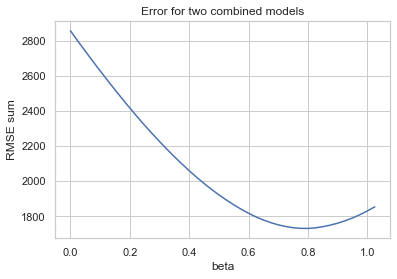

In [136]:
plt.figure()
plt.plot(list(beta_results_rmse.keys()), list(beta_results_rmse.values()))
plt.xlabel("beta")
plt.ylabel("RMSE sum")
plt.title("Error for two combined models")
plt.show()

In [139]:
min(beta_results_rmse, key=beta_results_rmse.get)

0.8

лучше всего при beta 0.8
не знаю, с чем именно это связанно
но вот так получилось